In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D

import re

from Utilities.EvaluationMain import *
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects
from Models.Caller import *
from BatchMIEvaluation import LoadModelConfigs, LoadParams
from Utilities.Visualization import VisReconGivenZ_FCA, HeatMapFreqZ_FCA, VisReconGivenFC_ZA, VisReconExtractZ_FC


In [3]:
def extract_dimension(model):
    match = re.search(r'\d{2}', model)
    return match[0] if match else None

def add_underbrace(ax, center, text, width=2.0, height=0.2, y_offset=-0.15):
    """
    Adds an 'underbrace' outside the plot axes.

    Parameters:
    - ax: The axis object to add the underbrace to.
    - center: The center x position of the underbrace.
    - text: The label text to place under the underbrace.
    - width: The width of the underbrace.
    - height: The height of the underbrace.
    - y_offset: The y-axis offset for the underbrace and text.
    """
    # Create an arc (i.e., the underbrace)
    arc = patches.Arc((center, y_offset), width=width, height=height, angle=0,
                      theta1=180, theta2=0, color='black', lw=1.5)
    
    # Disable clipping (so the arc can be drawn outside the axes)
    arc.set_clip_on(False)
    ax.add_patch(arc)
    
    # Add the label text under the arc, disable clipping
    text_artist = ax.text(center, y_offset - (height / 2)-0.1, text, ha='center', va='top', fontsize=12)
    text_artist.set_clip_on(False)


### Aggregation of Mutual Information Tables for Model Evaluation

In [4]:
# Retrieve and filter Mutual Information (MI) table names from directories
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

MItableList = [tab for tab in TableList if 'MI' in tab and 'Nj1.' in tab]
BMMItableList = [tab for tab in BMtableList if 'MI' in tab and 'Nj1.' in tab]

# Initialize DataFrames and concatenate tables for MI datasets
MItableSet = pd.DataFrame()
for tab in MItableList:
    MItables = pd.read_csv('./EvalResults/Tables/' + tab)
    MItableSet = pd.concat([MItableSet, MItables], axis=0)

BMMItableSet = pd.DataFrame()
for tab in BMMItableList:
    MItables = pd.read_csv('./Benchmarks/EvalResults/Tables/' + tab)
    BMMItableSet = pd.concat([BMMItableSet, MItables], axis=0)

# Combine MI tables from main and benchmark sets
MItableSet = pd.concat([MItableSet, BMMItableSet])

In [4]:
MItableSet['Model'].unique(), MItableSet['Metrics'].unique()

(array(['FACFC_ART_30_500', 'FACFC_ART_50_500', 'SKZFC_ART_30_500',
        'SKZFC_ART_50_500', 'SKZ_ART_30_500', 'SKZ_ART_50_500',
        'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_50_500', 'FACFC_ART_30_800',
        'FACFC_ART_50_800', 'SKZFC_ART_30_800', 'SKZFC_ART_50_800',
        'SKZ_ART_30_800', 'SKZ_ART_50_800', 'TCMIDKZFC_ART_30_800',
        'TCMIDKZFC_ART_50_800', 'FACFC_II_30_500', 'FACFC_II_50_500',
        'SKZFC_II_30_500', 'SKZFC_II_50_500', 'SKZ_II_30_500',
        'SKZ_II_50_500', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_50_500',
        'FACFC_II_30_800', 'FACFC_II_50_800', 'SKZFC_II_30_800',
        'SKZFC_II_50_800', 'SKZ_II_30_800', 'SKZ_II_50_800',
        'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_800', 'BaseVAE_ART_30',
        'BaseVAE_ART_50', 'FACVAE_ART_30', 'FACVAE_ART_50',
        'ConVAE_ART_30', 'ConVAE_ART_50', 'TCVAE_ART_30', 'TCVAE_ART_50',
        'BaseVAE_II_30', 'BaseVAE_II_50', 'FACVAE_II_30', 'FACVAE_II_50',
        'ConVAE_II_30', 'ConVAE_II_50', 'TCVAE

### Model Data Preparation and Renaming 

In [5]:
# Define lists of table names for ART and II categories
ARTTabList = ['BaseVAE_ART_30',   'ConVAE_ART_30', 'SKZ_ART_30_500', 'SKZFC_ART_30_500', 'SKZFC_ART_30_800',   'TCVAE_ART_30', 'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_30_800',   'FACVAE_ART_30', 'FACFC_ART_30_500', 'FACFC_ART_30_800',
              'BaseVAE_ART_50',   'ConVAE_ART_50', 'SKZ_ART_50_500', 'SKZFC_ART_50_500', 'SKZFC_ART_50_800',   'TCVAE_ART_50', 'TCMIDKZFC_ART_50_500', 'TCMIDKZFC_ART_50_800',   'FACVAE_ART_50', 'FACFC_ART_50_500', 'FACFC_ART_50_800']

IITabList = ['BaseVAE_II_30',   'ConVAE_II_30', 'SKZ_II_30_500', 'SKZFC_II_30_500', 'SKZFC_II_30_800',   'TCVAE_II_30', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_30_800',   'FACVAE_II_30', 'FACFC_II_30_500', 'FACFC_II_30_800',
             'BaseVAE_II_50',   'ConVAE_II_50', 'SKZ_II_50_500', 'SKZFC_II_50_500', 'SKZFC_II_50_800',   'TCVAE_II_50', 'TCMIDKZFC_II_50_500', 'TCMIDKZFC_II_50_800',   'FACVAE_II_50', 'FACFC_II_50_500', 'FACFC_II_50_800']


# Define a list of analytical metrics
AnalMetricList = ['(1) I(V;Z)', '(2) $I(V; \\acute{Z} \\mid Z)$']

# Initialize a dictionary for renaming models
ModelRename = {}
for model in MItableSet['Model'].unique():
    # Create a new model name based on specific patterns in the model string
    if bool(re.search('_\d{3}', model)):
        ModelRename[model] = model[:-6]  + model[-3:-2] + 's'
    else:
        ModelRename[model] = model[:-3] 

    # Special renaming condition for models containing 'Base'
    if 'Base' in model:
        ModelRename[model] = 'B-VAE' 

        

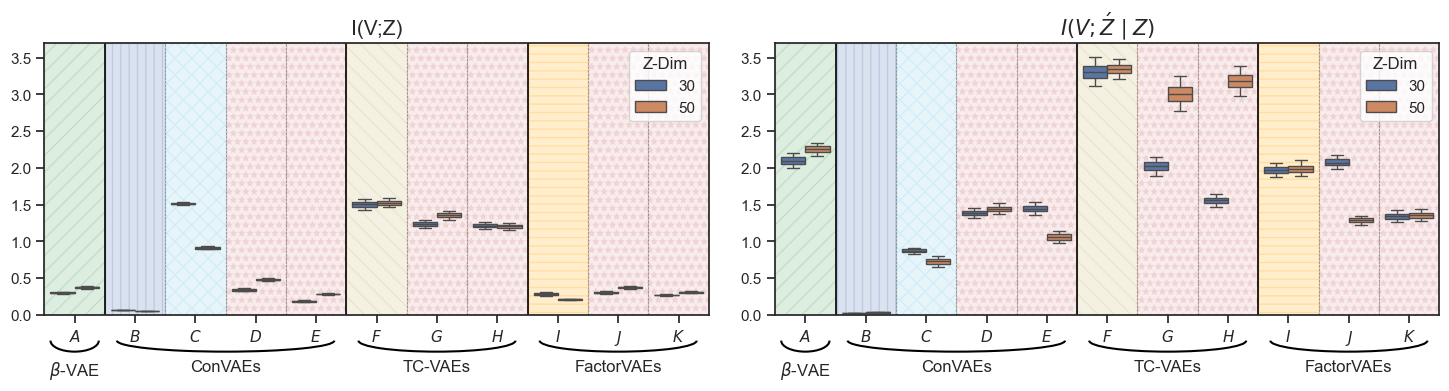

In [10]:
# Set the table list for analysis and determine the NZ (New Zealand) list based on the first item in the list
AnalTabList = ARTTabList  # Change to IITabList or ARTTabList as needed

# Filter the MI table set for analysis based on the specified tables and metrics
AnalMItableSet = MItableSet[(MItableSet['Model'].isin(AnalTabList)) & (MItableSet['Metrics'].isin(AnalMetricList))].reset_index(drop=True)
AnalMItableSet['MetricNew'] = AnalMItableSet['Metrics'].str[4:]  # Extract new metric names
metrics_categories = AnalMItableSet['MetricNew'].unique()

# Rename models in the analysis table set and update the table list
AnalMItableSet['Z-Dim'] = AnalMItableSet['Model'].apply(extract_dimension)
AnalMItableSet['Model'] = AnalMItableSet['Model'].map(ModelRename)

# Create a unique list 'UniqAnalTabList' that contains only the first occurrence of each item.
AnalTabList = [ModelRename[item] if item in ModelRename else item for item in AnalTabList]
UniqAnalTabList = []
seen = set()
for item in AnalTabList:
    if item not in seen:
        UniqAnalTabList.append(item)
        seen.add(item)

# Create model labels and a dictionary for mapping models to these labels
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
ModelLabels = [f'${letter}$' for letter in alphabet[:len(AnalTabList)]]
DictModelLabel = {model: f'${alphabet[i]}$' for i, model in enumerate(UniqAnalTabList)}

# Sort the DataFrame based on a created sorting key
AnalMItableSet['SortKey'] = AnalMItableSet['Model'].map(DictModelLabel)
AnalMItableSet = AnalMItableSet.sort_values(by='SortKey').drop(columns=['SortKey'])

# Prepare for violin plot visualization
global_min = AnalMItableSet['Values'].min()
global_max = AnalMItableSet['Values'].max()
total_models = len(AnalTabList)
fixed_palette = sns.color_palette("Set2", total_models)

# Set up seaborn style
sns.set(style="ticks")

# Create subplots for each metric and NZ category
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
axes = axes.flatten()

# Plotting logic for each subplot
for i, metric in enumerate(metrics_categories):
    ax = axes[i]
    Subset = AnalMItableSet[AnalMItableSet['MetricNew'] == metric]

    # Sort models alphabetically based on the labels
    unique_models_subset = sorted(Subset['Model'].unique(), key=lambda x: DictModelLabel.get(x, ''))
    NumModels = len(unique_models_subset)

    for num, line_pos in enumerate ([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5 ]):
        if num in [0,  4, 7]:
            ax.axvline(x=line_pos, color='black', linestyle='-', linewidth=1.2)
        else:
            ax.axvline(x=line_pos, color='grey', linestyle='--', linewidth=0.5)

        
        if 'B-VAE' in unique_models_subset[num]:
            ax.axvspan(line_pos-1., line_pos, facecolor='g', alpha=0.2, hatch='//', edgecolor='g')
        elif  'ConVAE_' in unique_models_subset[num]:
            ax.axvspan(line_pos-1., line_pos, facecolor='b', alpha=0.2, hatch='||', edgecolor='b')
        elif  'TCVAE_' in unique_models_subset[num]:
            ax.axvspan(line_pos-1., line_pos, facecolor='y', alpha=0.2, hatch='\\\\', edgecolor='y')
        elif  'FACVAE_' in unique_models_subset[num]:
            ax.axvspan(line_pos-1., line_pos, facecolor='orange', alpha=0.2, hatch='--', edgecolor='orange')
        elif  'SKZ_' in unique_models_subset[num]:
            ax.axvspan(line_pos-1., line_pos, facecolor='skyblue', alpha=0.2, hatch='xx', edgecolor='skyblue')
        else:
            ax.axvspan(line_pos-1., line_pos, facecolor='r', alpha=0.1, hatch='**', edgecolor='r')
        
    sns.boxplot(x='Model', y='Values', hue='Z-Dim', data=Subset, ax=ax, showfliers=False, whis=[5, 95], hue_order=['30', '50'])

    if 'ART' in AnalMItableSet['Model'][0]: 
        y_offset = -0.35
    else: 
        y_offset = -0.2
    
    # Add underbraces with the function
    add_underbrace(ax, 0, '$\\beta$-VAE', width=0.8, height=0.3 ,y_offset=y_offset)
    add_underbrace(ax, 2.5, 'ConVAEs', width=3.6, height=0.3 ,y_offset=y_offset)
    add_underbrace(ax, 6, 'TC-VAEs', width=2.6, height=0.3 ,y_offset=y_offset)
    add_underbrace(ax, 9, 'FactorVAEs', width=2.6, height=0.3 ,y_offset=y_offset)
    
    ax.set_title(metric , fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(range(NumModels))
    ax.set_xticklabels([DictModelLabel[model] for model in unique_models_subset])
    if 'ART' in AnalMItableSet['Model'][0]:
        ax.set_ylim([0, 3.7])
    elif 'II' in AnalMItableSet['Model'][0]:
        ax.set_ylim([0, 2.5])

# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2, wspace=0.1, hspace=0.4)

# Prepare and sort labels
sorted_labels = sorted(DictModelLabel.items(), key=lambda x: x[1])

# Determine positions for two rows and six columns
positions = []
for i in range(5):  # Two rows
    for j in range(5):  # Six columns
        x = 0.19 + j * 0.131  # Adjust horizontal spacing and starting position as needed
        y = 0.08 - i * 0.045  # Adjust vertical spacing and starting position as needed
        positions.append((x, y))

# Set the limits of the y-axis to make room for the underbraces
ax.set_ylim(bottom=0)



if 'ART' in AnalMItableSet['Model'][0]:
    plt.savefig('./EvalResults/Figures/VP_ART.png', bbox_inches='tight')
else:
    plt.savefig('./EvalResults/Figures/VP_II.png', bbox_inches='tight')

plt.show()


### Tabulating for result check

In [7]:
# Group the MI table set by 'Model' and 'MetricNew', calculate the mean, and reset the index
AnalMItableEval = AnalMItableSet[['Model', 'MetricNew', 'Values', 'Z-Dim']].groupby(['Model', 'MetricNew', 'Z-Dim']).mean().reset_index().copy()
# Create a sorting key by mapping the 'Model' column through the DictModelLabel
AnalMItableEval['SortKey'] = AnalMItableEval['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key and reset the index
AnalMItableEval = AnalMItableEval.sort_values(by='SortKey').reset_index(drop=True)
# Drop the 'SortKey' column as it's no longer needed
AnalMItableEval = AnalMItableEval.drop(columns=['SortKey'])

# Display the final DataFrame
AnalMItableEval 
sorted_labels

[('B-VAE', '$A$'),
 ('ConVAE_ART', '$B$'),
 ('SKZ_ART_5s', '$C$'),
 ('SKZFC_ART_5s', '$D$'),
 ('SKZFC_ART_8s', '$E$'),
 ('TCVAE_ART', '$F$'),
 ('TCMIDKZFC_ART_5s', '$G$'),
 ('TCMIDKZFC_ART_8s', '$H$'),
 ('FACVAE_ART', '$I$'),
 ('FACFC_ART_5s', '$J$'),
 ('FACFC_ART_8s', '$K$')]

### Comparison with ablation models 
#### Define lists of table names for different categories and conditions in ART and II

In [8]:
TabList_ART_500 = ['SKZ_ART_30_500','SKZ_ART_50_500', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_500', 'SKZFC_ART_50_500', 'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_50_500', 'FACFC_ART_30_500', 'FACFC_ART_50_500']
TabList_ART_800 = ['SKZ_ART_30_800','SKZ_ART_50_800', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_800', 'SKZFC_ART_50_800', 'TCMIDKZFC_ART_30_800', 'TCMIDKZFC_ART_50_800', 'FACFC_ART_30_800', 'FACFC_ART_50_800']

TabList_II_500 = ['SKZ_II_30_500','SKZ_II_50_500', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_500', 'SKZFC_II_50_500', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_50_500', 'FACFC_II_30_500', 'FACFC_II_50_500']
TabList_II_800 = ['SKZ_II_30_800','SKZ_II_50_800', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_800', 'SKZFC_II_50_800', 'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_800', 'FACFC_II_30_800', 'FACFC_II_50_800'] 


TabList_II = ['ConVAE_II_30', 'ConVAE_II_50',   'SKZ_II_30_500','SKZ_II_30_800', 'SKZ_II_50_500','SKZ_II_50_800',  
              'SKZFC_II_30_500', 'SKZFC_II_30_800', 'SKZFC_II_50_500', 'SKZFC_II_50_800',
              'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_500', 'TCMIDKZFC_II_50_800', 
              'FACFC_II_30_500', 'FACFC_II_30_800', 'FACFC_II_50_500', 'FACFC_II_50_800']

TabList_ART = ['ConVAE_ART_30', 'ConVAE_ART_50',   'SKZ_ART_30_500','SKZ_ART_30_800', 'SKZ_ART_50_500','SKZ_ART_50_800',  
              'SKZFC_ART_30_500', 'SKZFC_ART_30_800', 'SKZFC_ART_50_500', 'SKZFC_ART_50_800',
              'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_30_800', 'TCMIDKZFC_ART_50_500', 'TCMIDKZFC_ART_50_800', 
              'FACFC_ART_30_500', 'FACFC_ART_30_800', 'FACFC_ART_50_500', 'FACFC_ART_50_800']

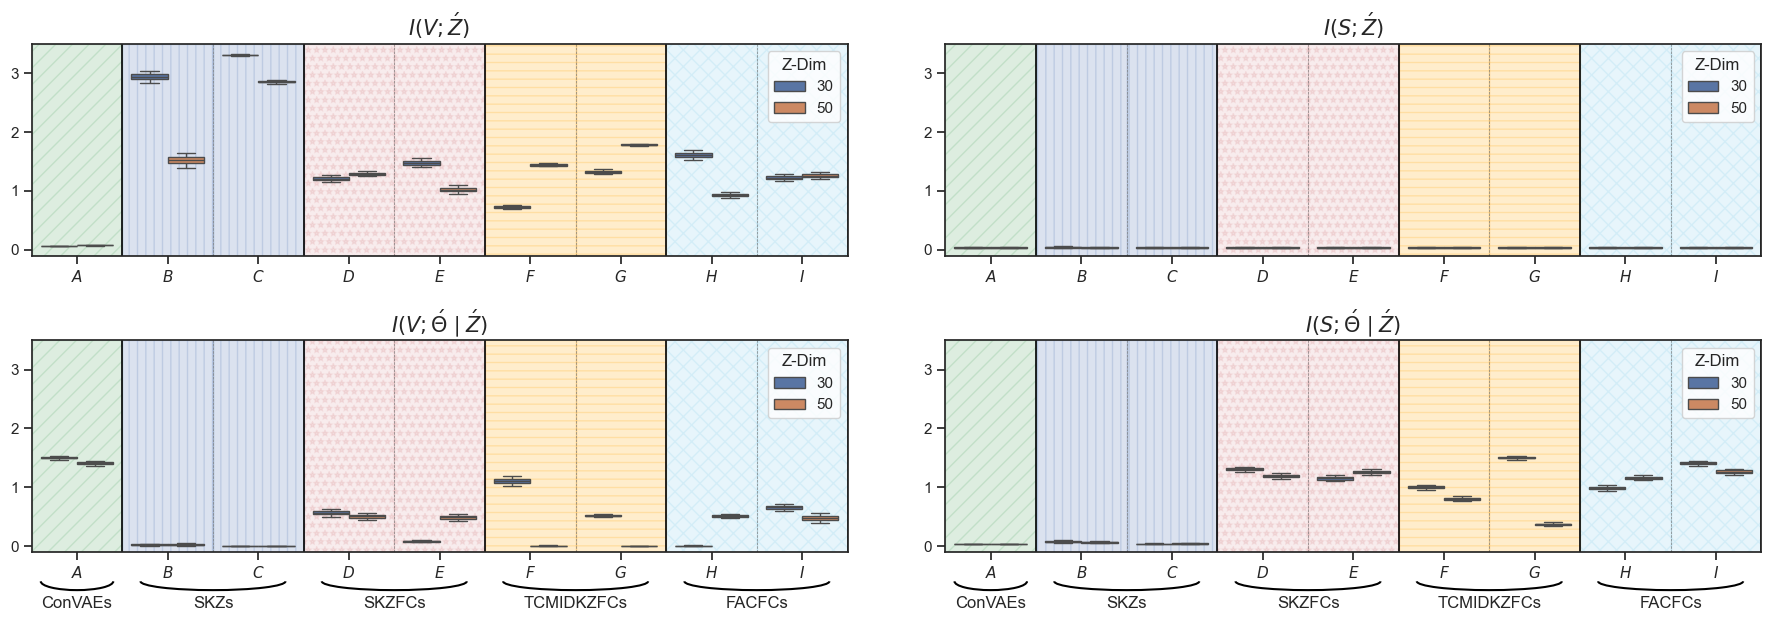

In [9]:
AnalTabList = TabList_ART  # TabList_II   TabList_ART
AnalMItableSet =  MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
AnalMItableSet['MetricNew'] = AnalMItableSet['Metrics'].str[4:]  # Extract new metric names
metrics_categories = AnalMItableSet['MetricNew'].unique()[2:]

# Rename models in the analysis table set and update the table list
AnalMItableSet['Z-Dim'] = AnalMItableSet['Model'].apply(extract_dimension)
AnalMItableSet['Model'] = AnalMItableSet['Model'].map(ModelRename)

# Retrieve unique values from the 'Metrics' column
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
ModelLabels = [f'${letter}$' for letter in alphabet[:len(AnalTabList)]]
AnalTabList = [ModelRename[item] if item in ModelRename else item for item in AnalTabList]

# Create a unique list 'UniqAnalTabList' that contains only the first occurrence of each item.
UniqAnalTabList = []
seen = set()
for item in AnalTabList:
    if item not in seen:
        UniqAnalTabList.append(item)
        seen.add(item)
        
DictModelLabel = {model: f"{ModelLabels[i]}" for i, model in enumerate(UniqAnalTabList)}

# Sort the DataFrame based on a created sorting key
AnalMItableSet['SortKey'] = AnalMItableSet['Model'].map(DictModelLabel)
AnalMItableSet = AnalMItableSet.sort_values(by='SortKey').drop(columns=['SortKey'])

# Prepare for violin plot visualization
global_min = AnalMItableSet['Values'].min()
global_max = AnalMItableSet['Values'].max()
total_models = len(AnalTabList)
fixed_palette = sns.color_palette("Set2", total_models)

# Set up seaborn style
sns.set(style="ticks")

# Create a 3x2 subplot structure
fig, axes = plt.subplots(2, 2, figsize=(18, 7))
axes = axes.flatten(order='F')

PlotIdx = 0
# Generate violin plots for each 'Metrics'
for ax, metric in zip(axes, metrics_categories):
    Subset = AnalMItableSet[AnalMItableSet['MetricNew'] == metric]

    # Sort models alphabetically based on the labels
    unique_models_subset = sorted(Subset['Model'].unique(), key=lambda x: DictModelLabel.get(x, ''))
    NumModels = len(unique_models_subset)
    palette = sns.color_palette("Set2", NumModels)

    for num, line_pos in enumerate ([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5 ]):
        if num in [0,  2, 4, 6, 8]:
            ax.axvline(x=line_pos, color='black', linestyle='-', linewidth=1.2)
        else:
            ax.axvline(x=line_pos, color='grey', linestyle='--', linewidth=0.5)

        
        if num in [0]:
            ax.axvspan(line_pos-1., line_pos, facecolor='g', alpha=0.2, hatch='//', edgecolor='g')
        elif  num in [1,2]:
            ax.axvspan(line_pos-1., line_pos, facecolor='b', alpha=0.2, hatch='||', edgecolor='b')
        elif  num in [3,4]:
            ax.axvspan(line_pos-1., line_pos, facecolor='r', alpha=0.1, hatch='**', edgecolor='r')
        elif  num in [5,6]:
            ax.axvspan(line_pos-1., line_pos, facecolor='orange', alpha=0.2, hatch='--', edgecolor='orange')
        elif  num in [7,8]:
            ax.axvspan(line_pos-1., line_pos, facecolor='skyblue', alpha=0.2, hatch='xx', edgecolor='skyblue')

    y_offset = - 0.6
    if PlotIdx % 2 !=0:
        # Add underbraces with the function
        add_underbrace(ax, 0, 'ConVAEs', width=0.8, height=0.3 ,y_offset=y_offset)
        add_underbrace(ax, 1.5, 'SKZs', width=1.6, height=0.3 ,y_offset=y_offset)
        add_underbrace(ax, 3.5 , 'SKZFCs', width=1.6, height=0.3 ,y_offset=y_offset)
        add_underbrace(ax, 5.5, 'TCMIDKZFCs', width=1.6, height=0.3 ,y_offset=y_offset)
        add_underbrace(ax, 7.5, 'FACFCs', width=1.6, height=0.3 ,y_offset=y_offset)
       
    
    sns.boxplot(x='Model', y='Values', hue='Z-Dim', data=Subset, ax=ax, showfliers=False, whis=[5, 95], hue_order=['30', '50'])


    ax.set_title(metric , fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(range(NumModels))
    ax.set_xticklabels([DictModelLabel[model] for model in unique_models_subset])
    ax.set_ylim([-0.1 , 3.5])

    PlotIdx += 1

plt.tight_layout()
# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2, wspace=0.12, hspace=0.4)
# Prepare and sort labels
sorted_labels = sorted(DictModelLabel.items(), key=lambda x: x[1])

CompLen = AnalMItableSet['Model'][0][-3:]
if 'ART' in AnalMItableSet['Model'][0]:
    plt.savefig('./EvalResults/Figures/VP_ART_ABL.png', bbox_inches='tight')
else:
    plt.savefig('./EvalResults/Figures/VP_II_ABL.png', bbox_inches='tight')

# Display the plot
plt.show()

### Tabulating

In [58]:
AnalMItableEval =  AnalMItableSet[['Model','MetricNew', 'Z-Dim', 'Values']].groupby(['Model','MetricNew', 'Z-Dim']).mean().reset_index().copy()
AnalMItableEval['SortKey'] = AnalMItableEval['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key
AnalMItableEval = AnalMItableEval.sort_values(by='SortKey').reset_index(drop=True)
# Now you can drop the 'SortKey' column if you don't need it anymore
AnalMItableEval = AnalMItableEval.drop(columns=['SortKey'])
AnalMItableEval[AnalMItableEval['MetricNew'].isin(metrics_categories)]

,Model,MetricNew,Z-Dim,Values
0,ConVAE_ART,$I(S;\acute{Z})$,30,0.036036
2,ConVAE_ART,$I(V;\acute{\Theta} \mid \acute{Z})$,50,1.406529
3,ConVAE_ART,$I(V;\acute{\Theta} \mid \acute{Z})$,30,1.502976
4,ConVAE_ART,$I(V;\acute{Z})$,50,0.072278
5,ConVAE_ART,$I(V;\acute{Z})$,30,0.060906
...,...,...,...,...
103,FACFC_ART_8s,$I(S;\acute{\Theta} \mid \acute{Z})$,50,1.263892
104,FACFC_ART_8s,$I(S;\acute{\Theta} \mid \acute{Z})$,30,1.407783
105,FACFC_ART_8s,$I(S;\acute{Z})$,30,0.036039
106,FACFC_ART_8s,$I(V;\acute{Z})$,30,1.220428


### Data Extraction and Categorization for result difference according to Nj

In [59]:
# Retrieve table names from directories
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

# Filter tables containing 'MI' in their names
MItableList = [tab for tab in TableList if 'MI' in tab]
BMMItableList = [tab for tab in BMtableList if 'MI' in tab]

# Function to extract Nj value from filename
def ExtractNj(Filename):
    Match = re.search(r'Nj(\d+)\.', Filename)
    return int(Match.group(1)) if Match else None

# Initialize DataFrames for ART and II MI tables
ARTMItableSet = pd.DataFrame()
IIMItableSet = pd.DataFrame()

# Process and categorize MI tables based on 'ART' or 'II' in their names
for tab in MItableList:
    Nj = ExtractNj(tab)
    MItables = pd.read_csv('./EvalResults/Tables/' + tab)
    MItables['Nj'] = Nj

    if 'ART' in tab:
        ARTMItableSet = pd.concat([ARTMItableSet, MItables], axis=0)
    elif 'II' in tab:
        IIMItableSet = pd.concat([IIMItableSet, MItables], axis=0)

# Process and rename SKZFC models for ART and II MI tables
SZKFC_II_MIs = IIMItableSet[IIMItableSet['Model'].str.contains('SKZFC')].reset_index(drop=True).copy()
SZKFC_ART_MIs = ARTMItableSet[ARTMItableSet['Model'].str.contains('SKZFC')].reset_index(drop=True).copy()

SZKFC_ART_MIs['ModelNj'] = SZKFC_ART_MIs['Model'].str[6:] + '_Nj' + SZKFC_ART_MIs['Nj'].astype('str')
SZKFC_ART_MIs['Model'] = SZKFC_ART_MIs['Model'].str[10:12] + 'D-Zj&' + SZKFC_ART_MIs['Model'].str[13:14] + 's'

SZKFC_II_MIs['ModelNj'] = SZKFC_II_MIs['Model'].str[6:] + '_Nj' + SZKFC_II_MIs['Nj'].astype('str')
SZKFC_II_MIs['Model'] = SZKFC_II_MIs['Model'].str[9:11] + 'D-Zj&' + SZKFC_II_MIs['Model'].str[12:13] + 's'


#### Visualization of Model Metrics across Nj Values with Boxplots and Line Plots

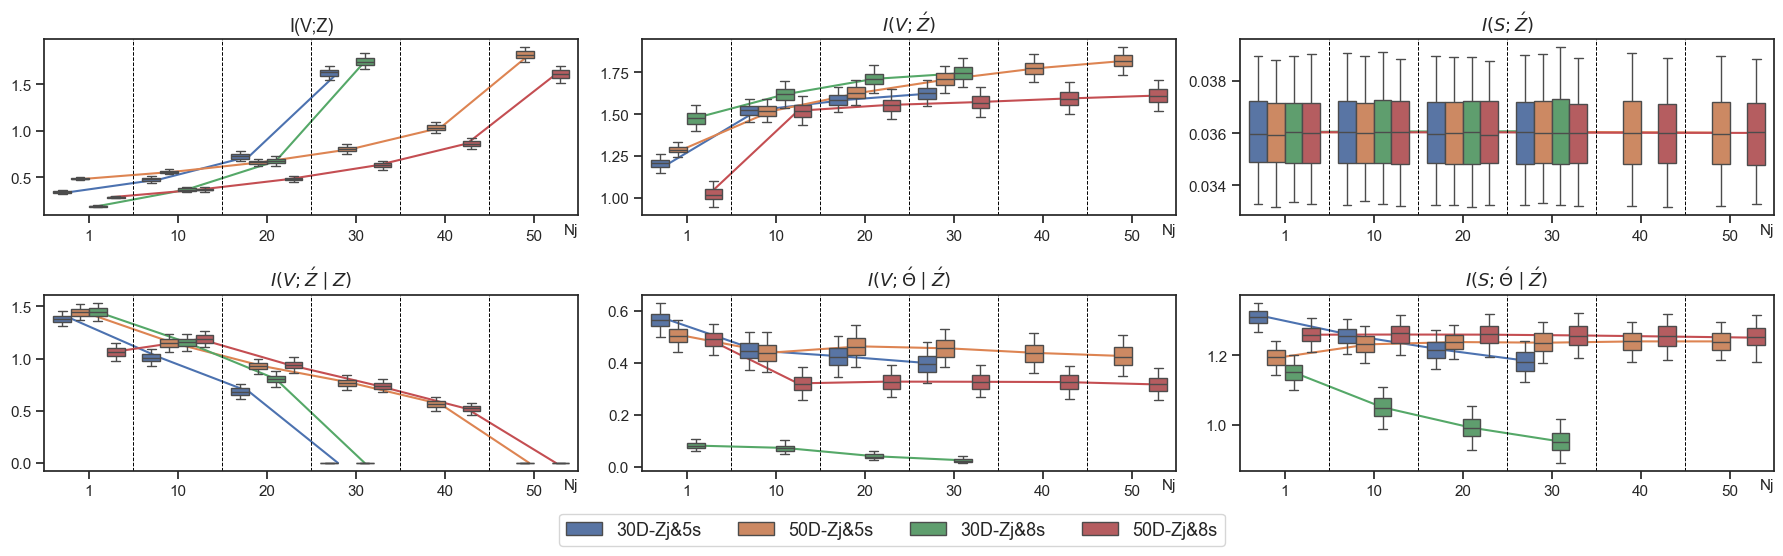

In [74]:
# Initialize variables for plotting
AnalMItableEval = SZKFC_ART_MIs  # Replace with SZKFC_ART_MIs or SZKFC_II_MIs as needed
SaveName = 'ART'

# Calculate global minimum and maximum values for setting y-axis limits
global_min = AnalMItableEval['Values'].min()
global_max = AnalMItableEval['Values'].max()

# Create a 2x3 subplot layout with specific figure size
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust space between plots

legend_handles = []  # List to collect legend handles

# Iterate through each unique metric and create corresponding plots
for i, metric in enumerate(AnalMItableEval['Metrics'].unique()):
    ax = axes[i % 2, i // 2]  # Determine the subplot position
    metric_data = AnalMItableEval[AnalMItableEval['Metrics'] == metric]

    # Prepare data for plotting
    all_nj_values = metric_data['Nj'].unique()
    position_dict = {nj: pos for pos, nj in enumerate(all_nj_values)}

    xmove = -0.2
    for j, model in enumerate(metric_data['Model'].unique()):
        model_data = metric_data[metric_data['Model'] == model]
        mean_values = model_data.groupby('Nj')['Values'].mean().reindex(all_nj_values)

        # Line plot for central tendency (mean) for each model
        ax.plot([position_dict[nj] + xmove for nj in mean_values.index], mean_values, label=None)
        xmove += 0.15

    
    for line_pos in [0.5, 1.5, 2.5, 3.5, 4.5]:
        ax.axvline(x=line_pos, color='black', linestyle='--', linewidth=0.7)
    
    # Box plot overlay and extract legend handles
    bplot = sns.boxplot(data=metric_data, x='Nj', y='Values', hue='Model', ax=ax, showfliers=False, whis=[5, 95])
    if i == 0:
        legend_handles = bplot.get_legend_handles_labels()[0]

    ax.set_title(metric[4:], fontsize=13)  # Set subplot titles
    ax.set_ylabel('')  # Optional: set y-label
    ax.set_xlabel('')  # Remove default x-label
    
    # Extend x-axis limits for text space, set custom x-label
    xlim = ax.get_xlim()
    #ax.set_xlim(xlim[0], xlim[1] + 0.1 * (xlim[1] - xlim[0]))
    ax.text(1.0, -0.12, 'Nj', ha='right', va='bottom', fontsize=11, transform=ax.transAxes)

    ax.set_xticks(np.arange(len(all_nj_values)))  # Set custom x-ticks
    ax.set_xticklabels(all_nj_values)  # Set x-tick labels
    ax.legend().set_visible(False)  # Hide individual subplot legends

plt.tight_layout()
plt.subplots_adjust(bottom=0.2, wspace=0.12, hspace=0.45)  # Adjust subplot parameters for padding

# Create a unified legend for the figure
fig.legend(handles=legend_handles, loc='lower center', ncol=len(legend_handles), bbox_to_anchor=(0.5, 0.06), fontsize=13)

# Save and display the plot
filename = './EvalResults/Figures/BP_ART_Njs.png' if 'ART' in SaveName else './EvalResults/Figures/BP_II_Njs.png'
plt.savefig(filename, bbox_inches='tight')
plt.show()


### 3D scatter plots

#### Define lists of table names for different categories and conditions in ART and II

In [21]:
TabList_ART_500 = ['SKZ_ART_30_500','SKZ_ART_50_500', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_500', 'SKZFC_ART_50_500', 'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_50_500', 'FACFC_ART_30_500', 'FACFC_ART_50_500']
TabList_ART_800 = ['SKZ_ART_30_800','SKZ_ART_50_800', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_800', 'SKZFC_ART_50_800', 'TCMIDKZFC_ART_30_800', 'TCMIDKZFC_ART_50_800', 'FACFC_ART_30_800', 'FACFC_ART_50_800']

TabList_II_500 = ['SKZ_II_30_500','SKZ_II_50_500', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_500', 'SKZFC_II_50_500', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_50_500', 'FACFC_II_30_500', 'FACFC_II_50_500']
TabList_II_800 = ['SKZ_II_30_800','SKZ_II_50_800', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_800', 'SKZFC_II_50_800', 'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_800', 'FACFC_II_30_800', 'FACFC_II_50_800']    

#### Aggregation of Accuracy Tables from Main and Benchmark Datasets

In [22]:
# Retrieve accuracy table names from specific directories
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

# Filter tables containing 'Acc' and 'Nj1.' in their names from both directories
AcctableList = [tab for tab in TableList if 'Acc' in tab and 'Nj1.' in tab]
BMAcctableList = [tab for tab in BMtableList if 'Acc' in tab and 'Nj1.' in tab]

# Initialize DataFrames for storing accuracy tables from main and benchmark datasets
AcctableSet = pd.DataFrame()
BMAcctableSet = pd.DataFrame()

# Read and concatenate accuracy tables from the main dataset
for tab in AcctableList:
    Acctables = pd.read_csv('./EvalResults/Tables/' + tab)
    AcctableSet = pd.concat([AcctableSet, Acctables], axis=0)

# Read and concatenate accuracy tables from the benchmark dataset
for tab in BMAcctableList:
    Acctables = pd.read_csv('./Benchmarks/EvalResults/Tables/' + tab)
    BMAcctableSet = pd.concat([BMAcctableSet, Acctables], axis=0)

# Combine accuracy tables from both main and benchmark datasets
AcctableSet = pd.concat([AcctableSet, BMAcctableSet])


In [23]:
# Combine various ART and II tab lists for comprehensive analysis
AnalTabList = TabList_ART_800 + TabList_ART_500 + TabList_II_500 + TabList_II_800
# Define the list of metrics for detailed analysis
AnalMetricList = ['(2) $I(V; \\acute{Z} \\mid Z)$', '(4) $I(V;\\acute{\\Theta} \\mid \\acute{Z})$', '(6) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$']
# Filter and reset index for Mutual Information (MI) table set based on Analysis Tab List
AnalMItableSet = MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
# Filter and reset index for Accuracy table set based on Analysis Tab List
AnalAcctableSet = AcctableSet[(AcctableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
# Normalization and preparation of Accuracy table set
AnalAcctableSet['MAPEnorm'] = AnalAcctableSet['MAPEnorm'] / 100
# Select only relevant columns ('Model', 'MeanKldRes', 'MAPEnorm') for analysis
AnalAcctableSet = AnalAcctableSet[['Model', 'MeanKldRes', 'MAPEnorm']].copy()


In [24]:
def Normalization(series):
    # Normalize a numeric series using min-max normalization
    return (series - series.min()) / (series.max() - series.min()) if np.issubdtype(series.dtype, np.number) else series

# Filter the MI table set for models in the Analysis Tab List and reset the index
AnalMItableSet = MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
# Group data by 'Model' and 'Metrics', calculate the mean, and reset the index
AnalMItableSet = AnalMItableSet.groupby(['Model', 'Metrics']).mean().reset_index().copy()
# Filter rows where 'Metrics' are in the list of analytical metrics and reset the index
AnalMItableSet = AnalMItableSet[AnalMItableSet['Metrics'].isin(AnalMetricList)].reset_index(drop=True)
# Pivot the table to have 'Model' as rows, 'Metrics' as columns, and 'Values' as cell values
AnalMItableSet = pd.pivot(AnalMItableSet, index='Model', columns='Metrics', values='Values').reset_index().copy()
# Rename columns to more descriptive names
AnalMItableSet.columns = ['Model', 'Disentanglement', 'InfoGain'+'$\\Theta$', 'Controllability']
# Apply normalization to each column of the table
NormAnalMItableSet = AnalMItableSet.apply(Normalization)
# Merge normalized MI table with Accuracy table and sort by 'Model'
AnalAccMItable = pd.merge(AnalAcctableSet, AnalMItableSet, on='Model', how='inner').sort_values('Model').reset_index(drop=True)



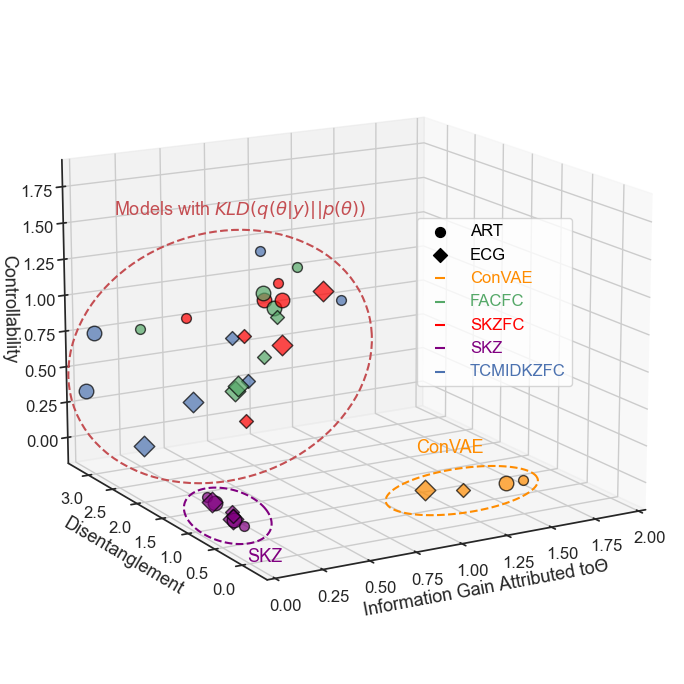

In [55]:
def add_ellipse_to_plot(ax, center, width, height, depth, color='r', linestyle='--'):
    """
    Add an ellipse to a 3D plot.

    Parameters:
    - ax: The axis object to draw the ellipse on.
    - center: The (x, y, z) coordinates of the ellipse's center.
    - width: The width of the ellipse (in the x-direction).
    - height: The height of the ellipse (in the y-direction).
    - depth: The depth of the ellipse (in the z-direction).
    - color: The color of the ellipse line.
    - linestyle: The style of the ellipse line.
    """
    # Create an array of angles from 0 to 2*pi
    angles = np.linspace(0, 2 * np.pi, 100)

    # Calculate the ellipse points in 3D space
    x = center[0] + width * np.cos(angles)
    y = center[1] + height * np.sin(angles)
    z = center[2] + depth * np.sin(angles)  # Modify this for 3D effect

    # Plot the ellipse
    ax.plot(x, y, z, linestyle, color=color)



# Set the style of seaborn for the plot
sns.set(style="ticks")
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.tick_params(axis='x', labelsize=12) 
ax.tick_params(axis='y', labelsize=12) 
ax.tick_params(axis='z', labelsize=12) 

# Create empty lists to hold custom legend information
markers = []
colors = []
labels = []
sizes = []
MarkSig = {}
ColMod = {}
ModCol = {}

# Iterate over the rows of the dataframe to plot each point individually
for i, row in AnalAccMItable.iterrows():
    # Determine the marker style based on the 'Model' value
    if 'II' in row['Model']:
        marker = 'D'  # Use '*' for models containing 'II'
        MarkSig[marker] = 'ECG'
        if 'D' not in markers:
            markers.append('D')
            labels.append('Model contains II')
    elif 'ART' in row['Model']:
        marker = 'o'  # Use 'o' for models containing 'ART'
        MarkSig[marker] = 'ART'
        if 'o' not in markers:
            markers.append('o')
            labels.append('Model contains ART')
    else:
        marker = '.'  # Default marker
        if '.' not in markers:
            markers.append('.')
            labels.append('Other Models')


    # Adjust marker size based on 'Model' value
    if '30' in row['Model']:
        marker_size = 50
    elif '50' in row['Model']:
        marker_size = 110
    # Check if this size is already in the list for legends
    if marker_size not in sizes:
        sizes.append(marker_size)

    
    # Determine the color based on the 'Model' value
    if 'ConVAE' in row['Model'] :
        color = 'darkorange'  # Use gray for models containing 'ConVAE' or 'SKZ'
        ColMod[color] = 'ConVAE'
        ModCol['ConVAE'] = color
        if 'darkorange' not in colors:
            colors.append('darkorange')

    elif 'SKZ_' in row['Model']:
        color = 'purple'  # Use green for other models
        ColMod[color] = 'SKZ'
        ModCol['SKZ'] = color
        if 'purple' not in colors:
            colors.append('purple')
    
    elif 'SKZFC' in row['Model']:
        color = 'red'  # Use green for other models
        ColMod[color] = 'SKZFC'
        ModCol['SKZFC'] = color
        if 'red' not in colors:
            colors.append('red')
    
    elif 'FACFC' in row['Model']:
        color = 'g'  # Use green for other models
        ColMod[color] = 'FACFC'
        ModCol['FACFC'] = color
        if 'g' not in colors:
            colors.append('g')
    
    elif 'TCMIDKZFC' in row['Model']:
        color = 'b'  # Use green for other models
        ColMod[color] = 'TCMIDKZFC'
        ModCol['TCMIDKZFC'] = color
        if 'b' not in colors:
            colors.append('b')

    # Plotting the points on the graph with the determined marker and color
    ax.scatter(row['InfoGain'+'$\\Theta$'], row['Disentanglement'], row['Controllability'],
               c=color, marker=marker, s=marker_size, alpha=0.7,edgecolors='black')  # Coloring based on the specified logic

    '''
    if i in Indices:
        ax.text(row['InfoGain'+'$\\Theta$']-0.05, row['Disentanglement'], row['Controllability'], row['Model'] , size=10, zorder=50)
    '''

    
# Create custom legends
for marker in markers:
    ax.scatter([], [], marker=marker, label=MarkSig[marker], c='black', s=50)
    
for color in colors:
    ax.scatter([], [], marker='_', label=ColMod[color], c=color, s=50)

# Set axis labels
ax.set_xlabel('Information Gain Attributed to'+'$\\Theta$', fontsize=13)  # Label for the x-axis Information Gain Attributed to Theta
ax.set_ylabel('Disentanglement', fontsize=13)  # Label for the y-axis
ax.set_zlabel('Controllability', fontsize=13)  # Label for the z-axis

ax.set_xlim([0, 2])


# Parameters for the ellipse
ellipse_params1 = {
    'center': [0.1, 0.8, 1.0],  # 'InfoGain'+'$\\Theta$', 'Disentanglement', 'Controllability'
    'width': 0.8,  # The width (in the InfoGain'+'$\\Theta$)
    'height': .1,  # The height (in the Disentanglement)
    'depth': 0.8,  # The depth (in the Controllability)
    'color': 'r',  # The color of the ellipse
    'linestyle': '--'  # The line style of the ellipse
}

ellipse_params2 = {
    'center': [0.0, 0.40, 0.05],  # 'InfoGain'+'$\\Theta$', 'Disentanglement', 'Controllability'
    'width': 0.2,  # The width (in the InfoGain'+'$\\Theta$)
    'height': 0.4,  # The height (in the Disentanglement)
    'depth': 0.1,  # The depth (in the Controllability)
    'color': 'purple',  # The color of the ellipse
    'linestyle': '--'  # The line style of the ellipse
}

ellipse_params3 = {
    'center': [1.15, 0.0, 0.05],  # 'InfoGain'+'$\\Theta$', 'Disentanglement', 'Controllability'
    'width': 0.42,  # The width (in the InfoGain'+'$\\Theta$)
    'height': 0.2,  # The height (in the Disentanglement)
    'depth': 0.1,  # The depth (in the Controllability)
    'color': 'darkorange',  # The color of the ellipse
    'linestyle': '--'  # The line style of the ellipse
}

# Add an ellipse to the plot
add_ellipse_to_plot(ax, **ellipse_params1)
add_ellipse_to_plot(ax, **ellipse_params2)
add_ellipse_to_plot(ax, **ellipse_params3)

ax.text(0.6, 4.8, 1.25, 'Models with ' + '$KLD(q(\\theta | y) || p(\\theta))$' , size=13, zorder=50, color='r')
ax.text(0.1, 0.4, -0.28, 'SKZ' , size=13, zorder=50, color='purple')
ax.text(1.2, 0.95, 0.11, 'ConVAE' , size=13, zorder=50, color='darkorange')

# Display the legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(0.6, 0.7), fontsize=12)
# Set the text color for each legend item
ModCol['ART'] = 'black'
ModCol['ECG'] = 'black'
for text in legend.get_texts():
    text.set_color(ModCol[text.get_text()])
    
ax.view_init(elev=15, azim=240) #ax.view_init(elev=30, azim=240)

# Adjust the layout to make room for the legend
#plt.tight_layout(pad=5)
plt.tight_layout()
plt.savefig('./EvalResults/Figures/3D_Scatter.png', bbox_inches='tight')

# Display the plot
plt.show()


## 2D scatter plots
#### Data Aggregation and Normalization for Model Performance Analysis

In [61]:
# Define benchmark lists for ART and II categories
ARTBenchList = ['BaseVAE_ART_30', 'TCVAE_ART_30', 'FACVAE_ART_30', 'BaseVAE_ART_50', 'TCVAE_ART_50', 'FACVAE_ART_50']
IIBenchList = ['BaseVAE_II_30', 'TCVAE_II_30', 'FACVAE_II_30', 'BaseVAE_II_50', 'TCVAE_II_50', 'FACVAE_II_50']

# Combine various ART and II tab lists including benchmarks for comprehensive analysis
AnalTabList = TabList_ART_800 + TabList_ART_500 + TabList_II_500 + TabList_II_800 + ARTBenchList + IIBenchList

# Define metrics for analysis
AnalMetricList = ['(1) I(V;Z)', '(2) $I(V; \\acute{Z} \\mid Z)$', '(3) $I(V;\\acute{Z})$', 
                  '(4) $I(V;\\acute{\\Theta} \\mid \\acute{Z})$', '(5) $I(S;\\acute{Z})$', 
                  '(6) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$']

# Filter MI and Accuracy table sets for models in the Analysis Tab List and reset the index
AnalMItableSet = MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
AnalAcctableSet = AcctableSet[(AcctableSet['Model'].isin(AnalTabList))].reset_index(drop=True)

# Normalization and preparation of Accuracy table set
AnalAcctableSet['MAPEnorm'] = AnalAcctableSet['MAPEnorm'] / 100
AnalAcctableSet = AnalAcctableSet[['Model', 'MeanKldRes', 'MAPEnorm']].copy()

# Group, filter, and pivot the MI table set for analysis
AnalMItableSet = AnalMItableSet.groupby(['Model', 'Metrics']).mean().reset_index().copy()
AnalMItableSet = AnalMItableSet[AnalMItableSet['Metrics'].isin(AnalMetricList)].reset_index(drop=True)
AnalMItableSet = pd.pivot(AnalMItableSet, index='Model', columns='Metrics', values='Values').reset_index().copy()

# Apply normalization to the MI table set
NormAnalMItableSet = AnalMItableSet.apply(Normalization)

# Merge normalized MI table set with Accuracy table set, sort by 'Model', and reset index
AnalAccMItable = pd.merge(AnalAcctableSet, AnalMItableSet, on='Model', how='inner').sort_values('Model').reset_index(drop=True)


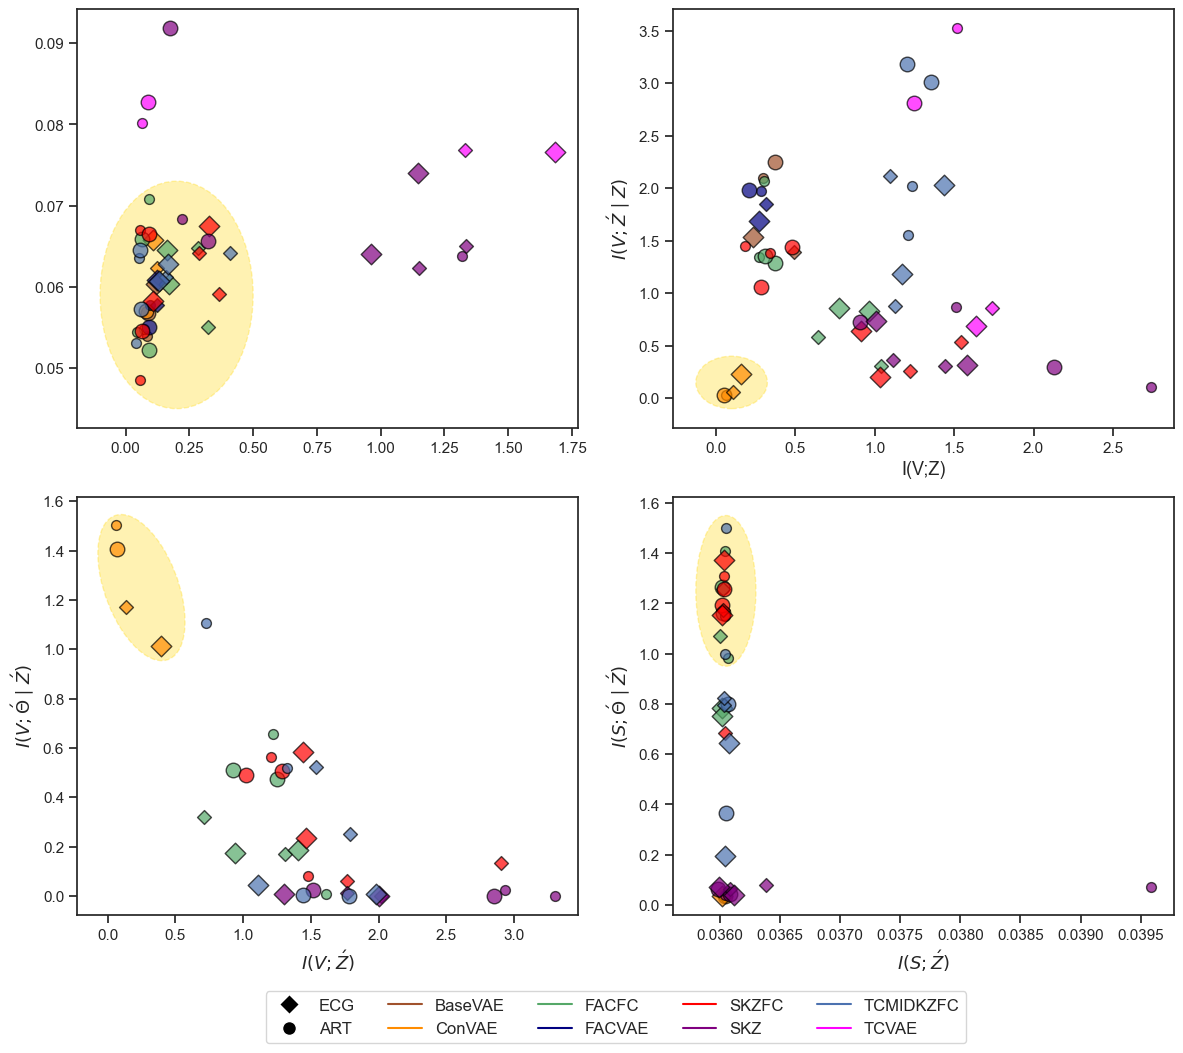

In [72]:
# Set up the plot style and create a 2x2 subplot structure
sns.set(style="ticks")
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define data columns for x and y axes and rename columns in the dataframe
data_columns = ['FQI', 'MAPE', '(1) I(V;Z)', '(2) $I(V; \\acute{Z} \\mid Z)$', 
                '(3) $I(V;\\acute{Z})$', '(4) $I(V;\\acute{\\Theta} \\mid \\acute{Z})$', 
                '(5) $I(S;\\acute{Z})$', '(6) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$']
AnalAccMItable = AnalAccMItable.rename(columns={'MeanKldRes':'FQI', 'MAPEnorm':'MAPE'})



# Define ellipse parameters for visual emphasis in subplots
ellipse_params = [
    {'center': (0.2, 0.059), 'width': 0.6, 'height': 0.028, 'angle': 0},
    {'center': (0.1, 0.15), 'width': 0.45, 'height': 0.5, 'angle': 0},
    {'center': (0.25, 1.25), 'width': 0.45, 'height': 0.75, 'angle': 50},
    {'center': (0.03605, 1.25), 'width': 0.0005, 'height': 0.6, 'angle': 0}
]


# Initialize variables for custom legend creation
unique_markers = set()
unique_colors = {}


# Iterate over each subplot
for subplot_index in range(4):
    ax = axs[subplot_index // 2, subplot_index % 2]

    # Select x and y columns
    x_column = data_columns[2 * subplot_index]
    y_column = data_columns[2 * subplot_index + 1]
    
    # Add ellipse to subplot
    params = ellipse_params[subplot_index]
    ellipse = Ellipse(params['center'], params['width'], params['height'], angle=params['angle'], color='gold', fill=True, linestyle='--', linewidth=1, alpha=0.3)
    ax.add_patch(ellipse)
    
    # Iterate over the rows of the dataframe to plot each point individually
    for i, row in AnalAccMItable.iterrows():
        # Determine the marker style based on the 'Model' value
        if 'II' in row['Model']:
            marker = 'D'  # Use '*' for models containing 'II'
            MarkSig[marker] = 'ECG'
            if 'D' not in markers:
                markers.append('D')
                labels.append('Model contains II')
        elif 'ART' in row['Model']:
            marker = 'o'  # Use 'o' for models containing 'ART'
            MarkSig[marker] = 'ART'
            if 'o' not in markers:
                markers.append('o')
                labels.append('Model contains ART')
        else:
            marker = '.'  # Default marker
            if '.' not in markers:
                markers.append('.')
                labels.append('Other Models')
    
    
        # Adjust marker size based on 'Model' value
        if '30' in row['Model']:
            marker_size = 50
        elif '50' in row['Model']:
            marker_size = 110
        # Check if this size is already in the list for legends
        if marker_size not in sizes:
            sizes.append(marker_size)
    
        
        # Determine the color based on the 'Model' value
        if 'ConVAE' in row['Model'] :
            color = 'darkorange'  # Use gray for models containing 'ConVAE' or 'SKZ'
            ColMod[color] = 'ConVAE'
            ModCol['ConVAE'] = color
            if 'darkorange' not in colors:
                colors.append('darkorange')
    
        elif 'SKZ_' in row['Model']:
            color = 'purple'  # Use green for other models
            ColMod[color] = 'SKZ'
            ModCol['SKZ'] = color
            if 'purple' not in colors:
                colors.append('purple')
        
        elif 'SKZFC' in row['Model']:
            color = 'red'  # Use green for other models
            ColMod[color] = 'SKZFC'
            ModCol['SKZFC'] = color
            if 'red' not in colors:
                colors.append('red')
        
        elif 'FACFC' in row['Model']:
            color = 'g'  # Use green for other models
            ColMod[color] = 'FACFC'
            ModCol['FACFC'] = color
            if 'g' not in colors:
                colors.append('g')
        
        elif 'TCMIDKZFC' in row['Model']:
            color = 'b'  # Use green for other models
            ColMod[color] = 'TCMIDKZFC'
            ModCol['TCMIDKZFC'] = color
            if 'b' not in colors:
                colors.append('b')
    
        elif 'BaseVAE' in row['Model']:
            color = 'sienna'  # Use green for other models
            ColMod[color] = 'BaseVAE'
            ModCol['BaseVAE'] = color
            if 'sienna' not in colors:
                colors.append('sienna')
    
        elif 'TCVAE' in row['Model']:
            color = 'magenta'  # Use green for other models
            ColMod[color] = 'TCVAE'
            ModCol['TCVAE'] = color
            if 'magenta' not in colors:
                colors.append('magenta')
    
        elif 'FACVAE' in row['Model']:
            color = 'navy'  # Use green for other models
            ColMod[color] = 'FACVAE'
            ModCol['FACVAE'] = color
            if 'navy' not in colors:
                colors.append('navy')

        # Plot the points on the graph
        ax.scatter(row[x_column], row[y_column], c=color, marker=marker, s=marker_size, alpha=0.7, edgecolors='black')

        # Track unique markers and colors for legend
        unique_markers.add((marker, MarkSig[marker]))  # Keep track of marker and its label
        unique_colors[color] = ColMod[color]  # Keep track of color and its label
    
    # Set axis labels
    ax.set_xlabel(x_column[4:], fontsize=13)
    ax.set_ylabel(y_column[4:], fontsize=13)
    '''
    ax.set_xlim(0, 3)
    if subplot_index ==0:
        ax.set_ylim(0.04, 0.08)
    else:
        ax.set_ylim(-0.1, 3.4)
    ''' 
# Create custom legend elements
legend_elements = []
for marker, label in unique_markers:
    legend_elements.append(Line2D([0], [0], marker=marker, color='w', label=label, markersize=10, markerfacecolor='black'))
for color, label in unique_colors.items():
    legend_elements.append(Line2D([0], [0], marker='', color=color, label=label, markersize=10, markerfacecolor=color))

# Create and display the unified legend at the bottom of the figure
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.52, -0.06), ncol=5, fontsize=12)

plt.tight_layout()

plt.savefig('./EvalResults/Figures/AllMetrics.png', bbox_inches='tight')

plt.show()